# Импорт и установка всего нужного

In [2]:
!pip install langdetect

In [144]:
import nltk
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import regex


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from langdetect import detect
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample,shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


c = collections.Counter()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stopword = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
shoes_data = pd.read_csv('Shoes_Data.csv')

# Задача 1

Считаем текст, лемматизируем и выкинем стоп-слова. Не будем распознавать языки, так как кажется все описания на английском либо на языке с другой (нелатинской письменностью). Поэтому просто выкинем нелатинский текст.

In [99]:
texts = []
prices = []


for descp in shoes_data['product_description']:
    cleared = regex.sub(r'[^\p{Latin}]', u' ', descp)
    tokens = tokenizer.tokenize(cleared.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens 
              if lemmatizer.lemmatize(token) not  in stopword]
    processed_text = ' '.join(lemmas)
    texts.append(processed_text)

prices = []

for price in shoes_data['price']:
    prices.append(price.lstrip('₹'))


df = pd.DataFrame({'Description': texts, 'Price': prices})
df['Price'] = pd.to_numeric(df['Price'])

Для начала нормализуем данные по цене.

In [100]:
normalized_df_price=(df['Price']-df['Price'].min())/(df['Price'].max()-df['Price'].min())

In [101]:
df['Price'] = normalized_df_price

Теперь заплотим их: видно, что есть много выбросов. Постараемся эти выбросы убрать. Для этого уберем все, что выходит за пределы 2 средних отклонений.

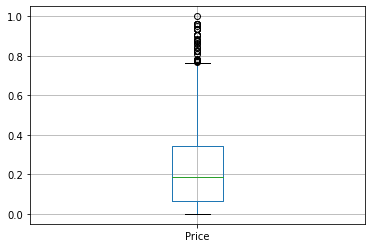

In [102]:
boxplot = df.boxplot(column=['Price'])

In [103]:
df_std = df[(np.abs(stats.zscore(df['Price'])) < 2)]

Снова заплотим. Стало лучше.

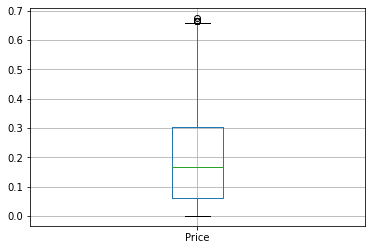

In [104]:
boxplot = df_std.boxplot(column=['Price'])

Построим две модели регрессии: Ridge CV и простую линейную регрессию. Посмотрим по средней абсолютной ошибке, какая лучшая.

In [105]:
parameters_ridge = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'regressor__normalize': (True, False)}

Посмотрим, сколько всего уникальных значений цены -- 590. Описаний у нас 1к с чем-то. То есть n_samples > n_features. Значит, будем использовать gcv_mode = 'auto' в Ridge CV.

In [106]:
len(df_std['Price'].unique())

590

In [131]:
ridge = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('regressor', RidgeCV(gcv_mode='auto'))])

train, test = train_test_split(df_std, test_size=0.2, random_state=42)

In [108]:
gs_clf_ridge = GridSearchCV(ridge, parameters_ridge, scoring='neg_mean_absolute_error', cv = 5)

gs_clf_ridge = gs_clf_ridge.fit(train['Description'], train['Price'])
print(gs_clf_ridge.best_score_)
print(gs_clf_ridge.best_params_)

-0.057939270645901444
{'regressor__normalize': False, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}


In [113]:
linear_regression = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('regressor', LinearRegression())])

In [114]:
parameters_linear_regression = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'regressor__normalize': (True, False)}

In [115]:
gs_clf_linear_regression = GridSearchCV(linear_regression, parameters_linear_regression, scoring='neg_mean_absolute_error', cv = 5)

gs_clf_linear_regression = gs_clf_linear_regression.fit(train['Description'], train['Price'])
print(gs_clf_linear_regression.best_score_)
print(gs_clf_linear_regression.best_params_)

-0.06334655058683886
{'regressor__normalize': True, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (2, 2)}


Лучший результат показывает Ridge CV. Посмотрим, как он справляется на тесте.

In [132]:
test = test.sort_values('Price')

In [133]:
preds = gs_clf_ridge.predict(test['Description'])

In [148]:
x = range(0, len(test['Price']))

Построим график с реальной ценой и предсказанной. Иногда модель ведет себя очень плохо. Можно видеть, что чем выше цена, тем хуже модель предсказывает ее, и на большой цене ее начинает "кренить" вниз. Возможно, это из-за того, что мы выкинули средние отклонения. Посмотрим на результат, если ничего не выкидывать из датафрейма.

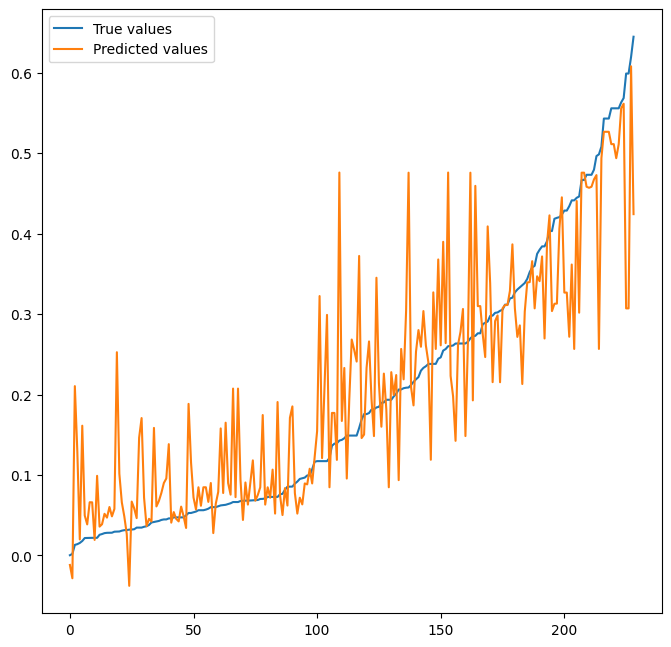

In [149]:
figure(figsize=(8, 8), dpi=100)
plt.plot(x, test['Price'], label = 'True values')
plt.plot(x, preds, label = 'Predicted values')
plt.legend()

In [136]:
train_2, test_2 = train_test_split(df, test_size=0.2, random_state=42)
gs_clf_linear_regression.fit(train['Description'], train['Price'])

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [150]:
test_2 = test_2.sort_values('Price')
preds_2 = gs_clf_ridge.predict(test_2['Description'])
x = range(0, len(test_2['Price']))

Можно видеть, что если оставить выбросы, то они негативно будут влиять на модель, они все равно на них не будет предсказывать близкие к корректным значения и будет "отягощаться" вниз, поэтому мы правильно сделали, что сначала убрали выбросы.

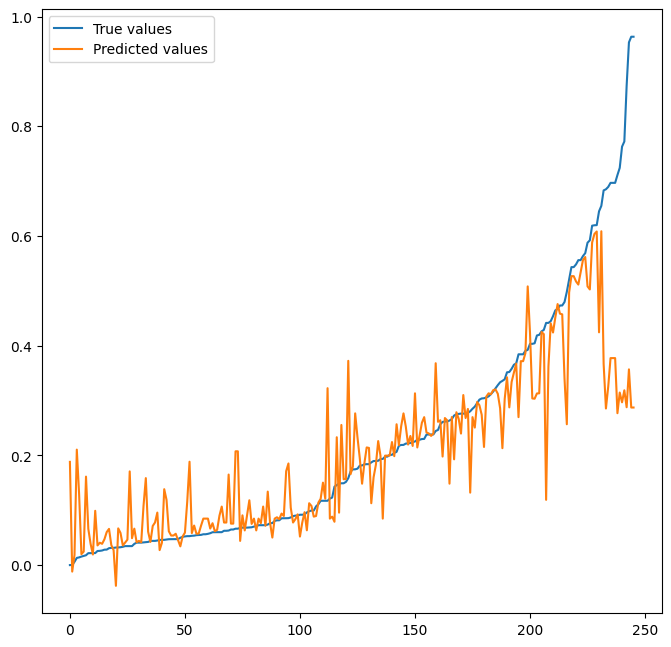

In [151]:
figure(figsize=(8, 8), dpi=100)
plt.plot(x, test_2['Price'], label = 'True values')
plt.plot(x, preds_2, label = 'Predicted values')
plt.legend()

Сравним метрики двух подходов. Сначала с убранными выбросами:

In [145]:
mse = mean_squared_error(test['Price'], preds)
me = mean_squared_error(test['Price'], preds, squared=False)
mae = mean_absolute_error(test['Price'], preds)

print('mse: ')
print(mse)
print('me: ')
print(me)
print('mae: ')
print(mae)

mse: 
0.00675941554354957
me: 
0.08221566483067305
mae: 
0.0539739601608981


Без убранных выбросов:

In [146]:
mse = mean_squared_error(test_2['Price'], preds_2)
me = mean_squared_error(test_2['Price'], preds_2, squared=False)
mae = mean_absolute_error(test_2['Price'], preds_2)

print('mse: ')
print(mse)
print('me: ')
print(me)
print('mae: ')
print(mae)

mse: 
0.01620944938093578
me: 
0.12731633587617805
mae: 
0.060916494418745235


С убранными выбросами модель дает лучшие метрики. Поэтому убирать их было правильным решением.

Качество модели можно улучшить, во-первых, засчет новых данных, которые бы охватывали все цены, чтобы выбросов стало меньше. Во-вторых можно еще посмотреть на "пол" обуви. Например, женские туфли в целом могут быть дороже мужских. 

Важным аспектом, который можно было бы в дальнейшем учесть являются названия. Можно было бы их также векторизовать или стараться вытащить именно названия марок (попробовать NER-тэггер, например, сделать это с помощью natasha). Обувь одной фирмы может быть в целом дороже, чем обувь другой. 

# Задача 2

Разбиваем ревью на каждый товар и оценки, делаем из этого один датафрейм. Токенезируем и лемматизируем текcты. Уберем стоп-слова. Также в процессе определим язык. Важно определять язык до лемматизации, так как это повысит эффективность определятора (чем когда он будет смотреть на лемматизированную строку). Я использую try-except, потому что библиотека не всегда может определить язык (недостаточно данных или просто пустая строка), в таком случае добавляю undetermined.

Кроме того, язык также важно определять именно распознавателем, потому что в отзывах есть языки с латинской письменностью. На них не будет работать лемматизация и это ненужный шум.


In [ ]:
#удалим not из стопслов, так как это может иметь значение при определении оценки
stopword.remove('not')
reviews_texts = []
languages = []
for reviews in shoes_data['reviews']:
  texts = reviews.split('|| ')
  for text in texts:
    try:
      languages.append(detect(text))
    except:
      languages.append('undetermined')
    tokens = tokenizer.tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens 
              if lemmatizer.lemmatize(token) not  in stopword]
    processed_text = ' '.join(lemmas)
    reviews_texts.append(processed_text)

In [ ]:
reviews_ratings = []

for reviews in shoes_data['reviews_rating']:
  ratings = reviews.split('|| ')
  for rating in ratings:
    reviews_ratings.append(rating[0])


Создаем датафрейм с текстом и оценкой. Конвертируем строки с оценкой в числа.

In [ ]:
df = pd.DataFrame({'Texts': reviews_texts, 'Ratings': reviews_ratings, 
                   'Lang': languages})
df['Ratings'] = pd.to_numeric(df['Ratings'])

Посмотрим сколько отзывов на каком языке написаны. Английский язык очень сильно доминирует. Можно также заметить, что в датасете есть отзывы на других языках с латинской письменностью. Имеет смысл делать анализ тональности только для английского языка. Так как лемматизация проводилась только для английского языка, а других языков много, но отзывов с ними мало -- они будут лишь играть роль информационного шума.

<BarContainer object of 35 artists>

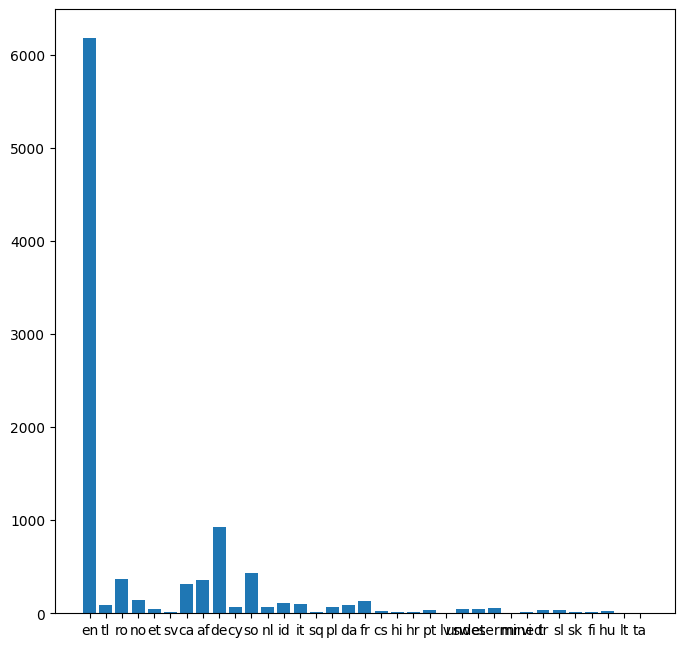

In [ ]:
for language in languages:
  c[language] += 1
figure(figsize=(8, 8), dpi=100)
plt.bar(c.keys(), c.values())

Часто в отзывах нет слов и они состоят только из оценки, это плохо, потому что пустая строка может быть у оценки 5, и оценки 2, и любой другой. Эта пустая строка сведет нашу модель с ума, поэтому выкинем ее.

Также выкинем отзывы не на английском языке.

In [ ]:
df.drop(df.loc[df['Texts']==''].index, inplace=True)
df.drop(df.loc[df['Texts']==' '].index, inplace=True)
df.drop(df.loc[df['Lang']!='en'].index, inplace=True)

Кроме того, просматривая тексты отзывов я наткнулся на словосочетания 'verified purchase' и 'report abuse', которое тоже свойственно разным оценкам. Поэтому его я тоже выкину

In [ ]:
df.drop(df.loc[df['Texts']=='verified purchase'].index, inplace=True)
df.drop(df.loc[df['Texts']=='report abuse'].index, inplace=True)

Посмотрим на количество отзывов для каждой из оценок. Видно, что больше всего отзывов с оценкой 5. 

С одной стороны, дисбаланс это плохо и может привести к переобучению. 

С другой стороны, есть [исследование](https://link.springer.com/chapter/10.1007/978-3-642-23851-2_17), что результаты на несбалансированном датасете даже оказываются в целом лучше. Однако в этом исследовании отзывы делились на положительные и отрицательные. В наших же данных -- пять оценок, поэтому будет разумно данные сбалансировать. Это можно сделать двумя способами: выкинуть часть данных (например, некоторое количество отзывов с оценкой 5) или продублировать некоторые отзывы (up sample). Но если мы будем дублировать отзывы, то сначала следует разделить на train и test, чтобы в test'е не было копий отзывов из train'а.

Разобьем данные на test и train с соотношением 0.8 и 0.2.

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

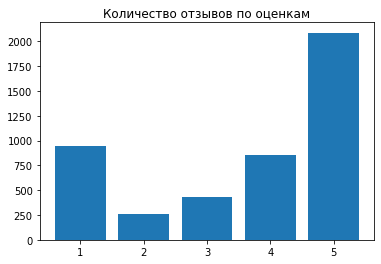

In [ ]:
values_reviews_numbers = [train[train.Ratings == 1].shape[0],
          train[train.Ratings == 2].shape[0],
          train[train.Ratings == 3].shape[0],
          train[train.Ratings == 4].shape[0],
          train[train.Ratings == 5].shape[0]]
bars = ('1', '2', '3', '4', '5')
y_pos = np.arange(len(bars))

plt.bar(y_pos, values_reviews_numbers)
plt.xticks(y_pos, bars)
plt.title('Количество отзывов по оценкам')
plt.show()

Еще один важный момент: количество отзывов важно, но не менее важна длина отзывов, поэтому прежде чем балансировать отзывы, нужно взглянуть на их длину. Например, в народе есть общее представление, что негативные отзывы в целом длиннее положительных. 

Посчитаем длину каждого отзыва и построим график.

In [ ]:
train['Text_length'] = train.Texts.str.split().str.len()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


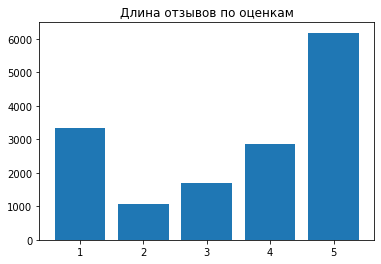

In [ ]:
values_reviews_len = [sum(train[train.Ratings == 1].Text_length.values),
                      sum(train[train.Ratings == 2].Text_length.values),
                      sum(train[train.Ratings == 3].Text_length.values),
                      sum(train[train.Ratings == 4].Text_length.values),
                      sum(train[train.Ratings == 5].Text_length.values)]
plt.bar(y_pos, values_reviews_len)
plt.xticks(y_pos, bars)
plt.title('Длина отзывов по оценкам')
plt.show()

Сделаем upsample всех отзывов (кроме отзывов с оценкой 5) до количества 1700.

In [ ]:
train_1 = train[train['Ratings'] == 1]
train_2 = train[train['Ratings'] == 2]
train_3 = train[train['Ratings'] == 3]
train_4 = train[train['Ratings'] == 4]
train_5 = train[train['Ratings'] == 5]

train_1_upsampled = resample(train_1,random_state=42,n_samples=1700,replace=True)
train_2_upsampled = resample(train_2,random_state=42,n_samples=1700,replace=True)
train_3_upsampled = resample(train_3,random_state=42,n_samples=1700,replace=True)
train_4_upsampled = resample(train_4,random_state=42,n_samples=1700,replace=True)

train_upsampled= pd.concat([train_5, train_1_upsampled, 
                            train_2_upsampled, train_3_upsampled,
                            train_4_upsampled])

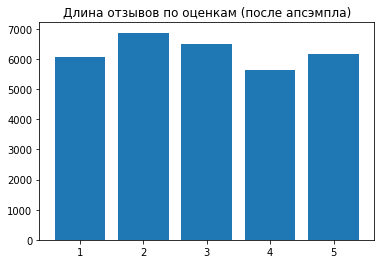

In [ ]:
values_reviews_len = [sum(train_upsampled[train_upsampled.Ratings == 1].Text_length.values),
                      sum(train_upsampled[train_upsampled.Ratings == 2].Text_length.values),
                      sum(train_upsampled[train_upsampled.Ratings == 3].Text_length.values),
                      sum(train_upsampled[train_upsampled.Ratings == 4].Text_length.values),
                      sum(train_upsampled[train_upsampled.Ratings == 5].Text_length.values)]
plt.bar(y_pos, values_reviews_len)
plt.xticks(y_pos, bars)
plt.title('Длина отзывов по оценкам (после апсэмпла)')
plt.show()

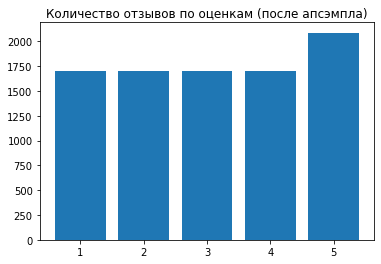

In [ ]:
values_reviews_numbers = [train_upsampled[train_upsampled.Ratings == 1].shape[0],
          train_upsampled[train_upsampled.Ratings == 2].shape[0],
          train_upsampled[train_upsampled.Ratings == 3].shape[0],
          train_upsampled[train_upsampled.Ratings == 4].shape[0],
          train_upsampled[train_upsampled.Ratings == 5].shape[0]]
bars = ('1', '2', '3', '4', '5')
y_pos = np.arange(len(bars))

plt.bar(y_pos, values_reviews_numbers)
plt.xticks(y_pos, bars)
plt.title('Количество отзывов по оценкам (после апсэмпла)')
plt.show()

Теперь построим два пайплайна. Возьмем базовую линейную модель для решения задачи: SVM. Сделаем гридсерч. Для SVM обычно используют One vs One Classifier. В качестве метрики возьмем f1_weighted (так как у нас мультиклассовая классификация).

Можно было бы взять и логистическую регрессию (с One vs Rest Classifier), но гридсерч по ее параметрам занял бы достаточно долгое количество времени, поэтому, чтобы его сэкономить оставим только SVM. 

In [ ]:
svm = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', OneVsOneClassifier(LinearSVC()))])


parameters_svm = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__estimator__penalty': ('l1', 'l2'),
               'clf__estimator__loss': ('hinge', 'squared_hinge'),
               'clf__estimator__multi_class': ('ovr', 'crammer_singer'),
               'clf__estimator__class_weight': ('balanced', None)}


gs_clf_svm = GridSearchCV(svm, parameters_svm, n_jobs=-1, scoring = "f1_weighted")
gs_clf_svm = gs_clf_svm.fit(train_upsampled['Texts'], train_upsampled['Ratings'])


print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.8321875910842718
{'clf__estimator__class_weight': None, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__multi_class': 'ovr', 'clf__estimator__penalty': 'l2', 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 2)}


В качестве второй модели воспользуемся не линейным подходом, а вероятностым и возьмем Multinomial Naive Bayes (у нас же мультиклассовая классификация). Кроме того, этот подход не нуждается в адаптере.

In [ ]:
nb = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', MultinomialNB())])


parameters_nb = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
               'tfidf__use_idf': (True, False),
               'tfidf__smooth_idf': (True, False),
               'tfidf__sublinear_tf': (True, False),
               'clf__alpha': (100, 10, 1, 0.1,
                                         0.01, 0.001, 0)}
               
gs_clf_nb = GridSearchCV(nb, parameters_nb, n_jobs=-1, scoring = "f1_weighted")

gs_clf_nb = gs_clf_nb.fit(train_upsampled['Texts'], train_upsampled['Ratings'])
print(gs_clf_nb.best_score_)
print(gs_clf_nb.best_params_)

0.8071562804650979
{'clf__alpha': 0.01, 'tfidf__smooth_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': False, 'vectorizer__ngram_range': (1, 2)}


Построим модель с подобранными гридсерчем гиперпараметрами.Обучим её на train'е.

Теперь предскажем значения для test'а и посмотрим на f1 weighted

In [ ]:
preds = gs_clf_svm.predict(test['Texts'])

Результат f1_weighted на кросс валидации

In [ ]:
scores = cross_val_score(gs_clf_svm, test['Texts'], test['Ratings'], cv=5, scoring='f1_weighted')

Можно заметить, что результаты получились хуже, чем в гридсерче, но это и неудивительно, ведь гридсерч производился на данных с дублированными отзывами.

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.55 accuracy with a standard deviation of 0.05


Построим график для каждого cv

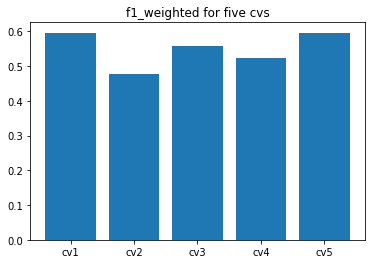

In [ ]:
labels = ('cv1', 'cv2', 'cv3', 'cv4', 'cv5')
plt.bar(y_pos, scores)
plt.xticks(y_pos, labels)
plt.title('f1_weighted for five cvs')
plt.show()

Построим confusion matrix. Как можно видеть, модель хорошо отличает друг от друга оценки 1,2,3 и 4,5. Это логично, так как 4 и 5 -- резко выраженные положительные оценки, а 1 и 2 -- отрицательные. 3 Согласно результатам больше тяготеет к негативным отзывам (например, часто оценку 1 модель путает с оценкой 3). С другой стороны, оценке 3 модель приписывает значение 4 больше, чем оценке 3 оценку 3. Это говорит о слаборазличимости оценки 3 (что неудивительно, ведь она находится посередине).

Модель хорошо отделяет оценки 4 и 5. Это неожиданно хорошо (я ожидал, что она будет их путать, потому что это оба положительные отзывы). Стоит отметить, что лучшие результаты получаются для оценок 5, 1 и 4. Это тройка оценок с наибольшим числом отзывов/наибольшей длиной.

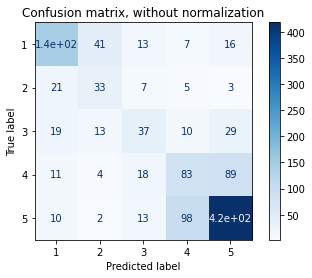

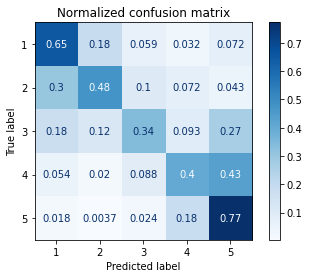

In [ ]:
class_names = [1, 2, 3, 4, 5]
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_clf_svm, test['Texts'], test['Ratings'],
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

Посмотрим также на classification report. Можно видеть, что чем выше изначальная длина слов/количество отзывов, тем лучше метрики.

In [ ]:
classification_report(test['Ratings'], preds, output_dict=True)

{'1': {'f1-score': 0.677570093457944,
  'precision': 0.7038834951456311,
  'recall': 0.6531531531531531,
  'support': 222},
 '2': {'f1-score': 0.40740740740740744,
  'precision': 0.3548387096774194,
  'recall': 0.4782608695652174,
  'support': 69},
 '3': {'f1-score': 0.3775510204081633,
  'precision': 0.42045454545454547,
  'recall': 0.3425925925925926,
  'support': 108},
 '4': {'f1-score': 0.40686274509803927,
  'precision': 0.4088669950738916,
  'recall': 0.40487804878048783,
  'support': 205},
 '5': {'f1-score': 0.7627737226277373,
  'precision': 0.7531531531531531,
  'recall': 0.7726432532347505,
  'support': 541},
 'accuracy': 0.6253275109170305,
 'macro avg': {'f1-score': 0.5264329977998583,
  'precision': 0.5282393797009282,
  'recall': 0.5303055834652403,
  'support': 1145},
 'weighted avg': {'f1-score': 0.6247813351524544,
  'precision': 0.6265752730525472,
  'recall': 0.6253275109170305,
  'support': 1145}}

Поэтому, чтобы улучшить модель, прежде всего, стоит пополнить ее большим количеством отзывов для оценок 2 и 3, которых сейчас мало.

Еще не помешает добавить отзывов с оценкой 4, чтобы модель лучше отделяла их от оценки 5. Ну или добавить еще отзывов с оценкой 5, потому что оценки 5 и 4 путаются чаще, чем 4 и 5. 